# Lab 2 - Leveraging spaCy for Comparative Textual EDA

In the last lab you learned about:
- spaCy's Doc object structure
- Token attributes (text, pos_, lemma_, is_stop, is_punct)
- Using the spaCy pipeline for tokenization, lemmatization, POS tagging, Parsing, and NER
- Iterating over tokens to extract linguistic features
- Exploring differences between classical NLP methods and LLM-based methods

**Learning Objectives:**
- Apply these tools to EDA and comparative analysis on a real dataset
- See how linguistic features help tease out social differences in the use of language
- Continue gaining intuition for classical NLP methods compared to LLM-based methods


**Useful References:**

- Brezina, Vaclav (2018). Statistics in Corpus Linguistics:
- A Practical Guide.
SpaCy API. https://spacy.io/api
- Possibility and Necessity. Chapter 16-16.2 in Analyzing Meaning - An Introduction to Semantics and Pragmatics (Kroeger)

Note about this lab: your focus should be on speculating and introspecting on observed phenomena. You'll be asked to consider how or why an LLM can do things that pose challenges for traditional NLP and statistical methods. As before, think and respond before asking an AI model for insight. We'll go much more deeply into how things work as we go in this class.

## Load libraries and models

In [1]:
# Environment (must run first)
from dotenv import load_dotenv
load_dotenv()
import data401_nlp
print(data401_nlp.__version__)

# Core libs
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import spacy

## Introduction to Corpus Design and EDA

In traditional corpus linguistics, the word corpus refers to a sample of language data that strives to be representative of a particular language variety. Language variety is a general term for language that shares one or more common traits, such as dialect, genre, or topic.

In this week's classroom activity, you examined corpora that were designed to study distributional properties of language. They were sampled with careful tracking of demographic and linguistic representativeness. They were also labeled with high quality annotations to capture linguistic features of interest. This sampling and annotation allows for reproducible, high-confidence analyses. 

That said, designed corpora come with a great amount of exploratory data analysis already included in metadata. For example, often included are descriptive statistics such as number of sentences, words, etc. Thus today, you will do EDA with basic statistics and analysis using SpaCy. You'll use NLP techniques such as parsing, pattern recognition, and named entity recognition, to infer labels and describe and compare two sets of related data. What you won't do at this point is assess the accuracy of your labeling. 


### The Purpose of EDA

Data collection and analysis serve one goal:  answering questions with data.  With that in mind, EDA serves a few purposes:
1. Ensure representativeness of the population or phenomenon under consideration
    - to make sure that the phenomena you seek are present in the data
    - to identify and account for outliers or other anomalies
2. Reveal characteristics of the data that might affect the generalizability or validity of your analysis
3. Provide insight into features that can be helpful in answering your data analytic questions


### Questions to Kick-off EDA

You can start an EDA by asking some fundamental questions, such as:
- How can I make sure my data is **representative** of the people or phenomena I want to describe?
- Do I have **enough data**?
    - e.g. if using a sentiment lexicon, do the words in the lexicon appear often enough to provide a basis for analysis
- What is the **structure of my data**?
    - threaded conversation-like discourse with identifiable speakers
        - Do I have enough information about the speakers to generalize about them?
        - Do I have enough text per speaker?
    - news articles that all start with a summary of new information
    - academic literature with a keyword list and abstract
    - sports reports where I might find tables with statistics
- What **metadata** is available?
    - user profiles with demographic information
    - topic lists
    - hashtags that might act like topic or discourse labels
- What **useful features can be derived** from the data?
    - would grouping the data into topics make sense?
    - do I need to extract person names or @mentions to answer the question at hand?

## Quick Refresher

Let's load our dataset into doc objects

In [2]:
from data401_nlp.helpers.spacy import ensure_spacy_model
nlp = ensure_spacy_model("en_core_web_sm")

df1 = pd.read_csv("../data/covidisreal_OR_wearamask_hashtag.csv")
df2 = pd.read_csv("../data/covidhoax_OR_notomasks_hashtag.csv")

df1['group'] = 'promask'
df2['group'] = 'antimask'
df = pd.concat([df1, df2], ignore_index=True)
df.groupby('group').head(4)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask
3,2020-08-31 02:07:16,NaN,0,140,So one day a guy will be bragging how he didn’...,promask
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask
5003,2020-08-31 02:01:45,CovidHoax,1,140,#CovidHoax is over... Let's OPEN the world and...,antimask


n Lab 1, we processed individual sentences. Today: what happens when we process thousands of tweets and compare patterns across two communities?

## Corpus-Level Overview

### Dataset Description

### Introduction 

Our goal for this lab is to do exploratory data analysis on a collection from Twitter.

Your dataset is comprised of two csv files. They were both collected in 2020 using [Tweepy](https://www.tweepy.org/), a Python library for accessing Twitter's API. Two searches were conducted, with a maximum number of English language tweets of 5000, and with retweets filtered out during collection.

Hashtags used for search were:
1. #covidhoax OR #notomask
2. #covidisreal OR #wearmask

This collection was created specifically for students of NLP in a prior semester. The data is not representative of any population and is not intended for publication or re-distribution. 

We will explore and describe your dataset using descriptive statistics first. Then we will compare the two collections using other spaCy capabilities.

Please do not share or post these csv files. Despite changes in Twitter ownership, they come with licensing restrictions. In the past, I had students collect this data individually. Since that's no longer an easy option, you will use pre-collected data. The [licensing restriction applicable to the 2020 collection is documented here](https://github.com/KatherineMichel/stanford-code-in-place-final-project/blob/master/twitter-developer-agreement-march-10.md). 

> You may not “sell, rent, lease, sublicense, distribute, redistribute, syndicate… or otherwise transfer or provide access to… the Licensed Material to any third party except as expressly permitted,” which means you should not give students a large raw dump designed to let them avoid having their own relationship with the API.

> In practice, for a small academic exercise: it is acceptable to share a modest tweet subset with students inside your course context, provided it is non‑commercial, secured, not a bulk replacement for the API, and you honor deletion/visibility changes and the privacy and usage rules in the Developer Policy.


## A - Token-Level Distributions

We'll start with basic descriptive statistics. In particular, we're interested in hashtag counts, token counts, word length, tweets (documents), and tweet (documnet) length.

Let's steps take a step back and think about what we are counting when we talk about tokens.

We already know **tokens** are a basic unit of processing. A **type** is a "distinct word form. In fact, we often think of words as canonical tokens.

From [spaCy documentation](https://spacy.io/api/lexeme):

- In spaCy, a **lexeme** is a *vocabulary entry* keyed by the hash of a string form (ORTH), representing a word type (form) with context‑independent attributes like casing, shape, and optional vector, but no token-level context such as POS or dependency.
- In spaCy, **A lexeme is “a word type, as opposed to a word token**,” stored in Vocab and shared by all tokens with the same ORTH (string hash).
- SpaCy maintains a StringStore mapping each distinct string to a unique integer ID; the same ID (ORTH) is used to index a Lexeme in Vocab.
- When a new string appears (e.g., during tokenization or when you access nlp.vocab["word"]), spaCy creates or retrieves the corresponding lexeme keyed by that ORTH value

While there are lots of ways to think about vocabulary and count things, you should always be careful to explain how you counted. In the function below, we are counting objects that:
- have already been pre-processed
- are lower-cased
- are not whitespace characters.


In [3]:
def get_vocab(texts, nlp):
    "Return set of unique token strings from texts"
    return {tok.text.lower() for doc in nlp.pipe(texts) for tok in doc if not tok.is_space}

promask_vocab = get_vocab(df[df.group=='promask'].tweet_text, nlp)
antimask_vocab = get_vocab(df[df.group=='antimask'].tweet_text, nlp)
combined_vocab = promask_vocab | antimask_vocab

dict(promask=len(promask_vocab), antimask=len(antimask_vocab), combined=len(combined_vocab), shared=len(promask_vocab & antimask_vocab))

{'promask': 17753, 'antimask': 8293, 'combined': 22939, 'shared': 3107}

In [4]:
def count_tokens(text):
    doc = nlp(text)
    return len(doc)

df['token_count'] = df['tweet_text'].apply(count_tokens)
df.groupby('group').head(3)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask,13
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask,23
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask,12
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask,30
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask,34
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask,31


Let's check for missing data.

In [5]:
df[['created_date', 'hashtags', 'num_hashtags', 'tweet_length', 'tweet_text', 'group']].isnull().sum()

created_date       0
hashtags        2419
num_hashtags       0
tweet_length       0
tweet_text         0
group              0
dtype: int64

We obviously don't care if hashtags are missing, though it is interesting that such a large number of tweets don't contain them. What do you think the absense of hashtags might indicate?

In [ ]:
df[df.duplicated(subset='tweet_text', keep=False)].sort_values('tweet_text').head(10)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count
5759,2020-08-27 19:36:10,COVID CovidHoax,2,121,@cangal21 Forced quarantine camps now operating in BC Canada...wake up people:\nhttps://t.co/VmxeAHxlSI\n#COVID \n#CovidHoax,antimask,22
5756,2020-08-27 19:37:56,COVID CovidHoax,2,121,@cangal21 Forced quarantine camps now operating in BC Canada...wake up people:\nhttps://t.co/VmxeAHxlSI\n#COVID \n#CovidHoax,antimask,22
5489,2020-08-29 04:32:47,masksavelives wearamask masksoff,3,138,@jadedcreative Yes everyone please virtue-signal like you give a damn. 👏🏽👏🏽👏🏽\n#masksavelives #wearamask #masksoff… https://t.co/GMNgj2ektY,antimask,28
3532,2020-08-29 04:32:47,masksavelives wearamask masksoff,3,138,@jadedcreative Yes everyone please virtue-signal like you give a damn. 👏🏽👏🏽👏🏽\n#masksavelives #wearamask #masksoff… https://t.co/GMNgj2ektY,promask,28
5484,2020-08-29 05:48:42,NaN,0,140,@letseathh @BBCNews Can you please explain to me why healthy ppl need to be under house arrest and wear a slave muz… https://t.co/juGFvG5QLe,antimask,24
3476,2020-08-29 05:48:42,NaN,0,140,@letseathh @BBCNews Can you please explain to me why healthy ppl need to be under house arrest and wear a slave muz… https://t.co/juGFvG5QLe,promask,24
5488,2020-08-29 04:42:07,masksavelives wearamask masksoff covid coronavirus,5,136,@markpoloncarz VIRTUE-SIGNALING DOES NOT SAVE LIVES. 👏🏽\n#masksavelives #wearamask #masksoff #covid #coronavirus… https://t.co/5DYRPmNlna,antimask,24
3528,2020-08-29 04:42:07,masksavelives wearamask masksoff covid coronavirus,5,136,@markpoloncarz VIRTUE-SIGNALING DOES NOT SAVE LIVES. 👏🏽\n#masksavelives #wearamask #masksoff #covid #coronavirus… https://t.co/5DYRPmNlna,promask,24
5768,2020-08-27 19:32:30,COVID CovidHoax,2,127,@roccogalatilaw Forced quarantine camps now operating in BC Canada...wake up people:\nhttps://t.co/VmxeAHxlSI\n#COVID \n#CovidHoax,antimask,22
5762,2020-08-27 19:35:14,COVID CovidHoax,2,127,@roccogalatilaw Forced quarantine camps now operating in BC Canada...wake up people:\nhttps://t.co/VmxeAHxlSI\n#COVID \n#CovidHoax,antimask,22


In [ ]:
df.duplicated(subset='tweet_text').sum()

np.int64(17)

Based on the duplicate examples shown, some may be tweets that matched both search queries (e.g., a tweet containing both #wearamask and #covidhoax hashtags). Since the two CSV files were collected separately using different hashtag searches, the same tweet could appear in both collections.

Let's start looking at tokens! Let's add a column that shows us tokenization with a simple split function. Recall that spaCy's tokenizer handles punctuation, contractions, URLs, etc. as separate tokens, while split() just breaks on spaces. Let's compare these two approaches with our data.

In [ ]:
df['split_count'] = df['tweet_text'].apply(lambda x: len(x.split()))
df.groupby('group').head(3)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask,13,9
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask,23,18
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask,12,7
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask,30,23
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask,34,25
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask,31,23


Let's grab one of these datasets and compare split() with spaCy tokenization by eyeballing a few tweets.

In [ ]:
for i in range(3):
    text = df['tweet_text'].iloc[i]
    doc = nlp(text)
    print(f"Tweet {i}:")
    print(f"  split(): {text.split()}")
    print(f"  spaCy:   {[tok.text for tok in doc]}")
    print()

Tweet 0:
  split(): ['#2020sucks', '#trumpisscar', '#ihateithere', '#wearamask', '@', 'Black', 'In', 'America', 'https://t.co/0xJHTodSHO']
  spaCy:   ['#', '2020sucks', '#', 'trumpisscar', '#', 'ihateithere', '#', 'wearamask', '@', 'Black', 'In', 'America', 'https://t.co/0xJHTodSHO']

Tweet 1:
  split(): ['This', 'is', 'probably', 'one', 'of', 'the', 'most', 'ridiculous', 'of', 'all', '#antimasker', '#antimasking', 'excuses', 'ever', 'recorded', '#DOJ', '#pandemic…', 'https://t.co/LQ53BRJVfI']
  spaCy:   ['This', 'is', 'probably', 'one', 'of', 'the', 'most', 'ridiculous', 'of', 'all', '#', 'antimasker', '#', 'antimasking', 'excuses', 'ever', 'recorded', '#', 'DOJ', '#', 'pandemic', '…', 'https://t.co/LQ53BRJVfI']

Tweet 2:
  split(): ['Just,', 'like,', 'do', 'it.', '#wearamask', '#maskuphoosiers', 'https://t.co/uaVHCyWnu2']
  spaCy:   ['Just', ',', 'like', ',', 'do', 'it', '.', '#', 'wearamask', '#', 'maskuphoosiers', 'https://t.co/uaVHCyWnu2']



Aaack! We want to keep our hashtags together! We need to look more carefully to see what else might be a problem.

Give me a fake tweet that let's me see a variety of text processing issues from Twitter. For example, puncuation, emoji, foreign characters.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠

Here's a fake tweet with a variety of text processing challenges:

```python
test_tweet = "OMG @DrFauci said #WearAMask!!! 😷🔥 But my café au lait ☕ costs $3.50... Can't breathe w/ masks 🙄 #COVID19 #NoToMasks https://t.co/fake123 RT: \"stay safe\" 👏👏👏 naïve ppl don't get it 😤"
```

This includes:
- @mentions and #hashtags
- Emoji (😷🔥☕🙄😤👏)
- Accented characters (café, naïve)
- Punctuation clusters (!!!, ...)
- Contractions (Can't)
- Currency ($3.50)
- URLs
- Quoted text
- Abbreviations (RT, OMG, ppl, w/)

Try running it through spaCy and `split()` to see how each handles these!

In [ ]:
test_tweet = "OMG @DrFauci said #WearAMask!!! 😷🔥 But my café au lait ☕ costs $3.50... Can't breathe w/ masks 🙄 #COVID19 #NoToMasks https://t.co/fake123 RT: \"stay safe\" 👏👏👏 naïve ppl don't get it 😤"

In [ ]:
test_tweet.split()

['OMG',
 '@DrFauci',
 'said',
 '#WearAMask!!!',
 '😷🔥',
 'But',
 'my',
 'café',
 'au',
 'lait',
 '☕',
 'costs',
 '$3.50...',
 "Can't",
 'breathe',
 'w/',
 'masks',
 '🙄',
 '#COVID19',
 '#NoToMasks',
 'https://t.co/fake123',
 'RT:',
 '"stay',
 'safe"',
 '👏👏👏',
 'naïve',
 'ppl',
 "don't",
 'get',
 'it',
 '😤']

In [ ]:
test_doc = nlp(test_tweet)
[word.text for word in test_doc]

['OMG',
 '@DrFauci',
 'said',
 '#',
 'WearAMask',
 '!',
 '!',
 '!',
 '😷',
 '🔥',
 'But',
 'my',
 'café',
 'au',
 'lait',
 '☕',
 'costs',
 '$',
 '3.50',
 '...',
 'Ca',
 "n't",
 'breathe',
 'w/',
 'masks',
 '🙄',
 '#',
 'COVID19',
 '#',
 'NoToMasks',
 'https://t.co/fake123',
 'RT',
 ':',
 '"',
 'stay',
 'safe',
 '"',
 '👏',
 '👏',
 '👏',
 'naïve',
 'ppl',
 'do',
 "n't",
 'get',
 'it',
 '😤']

Look through these carefully. What do you see beyond hashtags?

Let's see if we can use another approach to examine differences in tokenization.

Is there another (or better) approach to finding issues than what we did?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes! A few alternatives:

1. **Systematic comparison** — Find all tweets where `split()` and spaCy token counts differ significantly, then examine those cases

2. **Use spaCy's token attributes** — Check `token.is_punct`, `token.like_url`, `token.like_num`, etc. to see how spaCy is classifying things

3. **Look at the spaCy docs** — They document known tokenization behaviors and special cases

4. **Sample randomly** — Instead of crafting a test tweet, grab random real tweets and inspect them

Which approach appeals to you? Option 1 would be data-driven and might reveal issues specific to *your* corpus that we haven't thought of yet.

Let's pick the data-driven approach to look at documents that vary dramatically in token counts.

In [ ]:
df['token_diff'] = df['token_count'] - df['split_count']
pd.concat([df.sort_values('token_diff').head(10), df.sort_values('token_diff').tail(10)])

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count,token_diff
2257,2020-08-29 20:42:26,WearAMask,1,46,@TheLocalFrance Only 5000 new cases.#WearAMask,promask,5,5,0
4005,2020-08-28 23:06:37,WearAMask,1,69,Class mascots are ready for Monday.#WearAMask ...,promask,7,7,0
4025,2020-08-28 22:57:48,WearAMask,1,59,Also being responsible!!!#WearAMask https://t....,promask,4,4,0
1715,2020-08-30 03:45:25,WearAMask,1,70,Check out this item in my Etsy shop https://t....,promask,11,10,1
1795,2020-08-30 02:43:43,NaN,0,140,Our PNW neighbors state health dept still conc...,promask,17,16,1
2900,2020-08-29 15:08:41,NaN,0,140,@PoliceChiefs @SadiqKhan Could you please expl...,promask,21,20,1
2905,2020-08-29 15:06:11,NaN,0,140,I would think the supposed President spreading...,promask,21,20,1
2907,2020-08-29 15:03:55,NaN,0,140,@swtrains_watch @StopNewNormal Surely more evi...,promask,21,20,1
2859,2020-08-29 15:30:11,NaN,0,140,@Amicusc54803237 Oh Lord - I need to go and ch...,promask,27,26,1
6183,2020-08-25 22:43:37,NaN,0,139,@mayoroflasvegas @GovSisolak @CityOfLasVegas N...,antimask,17,16,1


In [ ]:
df.to_csv("tweets_with_tokens.csv", index=False)

#### Reflection

We've sorted to look where the two methods have few differences and those with many. What patterns do you notice? Look through examples and note your observations here. You can also export to a csv to make it easier to view.

#### Modify tokenization

It turns out that **if you want to pre-process data before it hits the tokenizer, you need to process that data before it hits the spacy pipeline**. We may or may not want to use this function, but I've created one to do this and have added a "clean_text" column to our dataframe. Some best practices are:
- Don't ever delete the original data
- Save every version you create and document what you've done (notebooks are very handy for this!)
- Don't get so tunnel visioned that you don't question you need to back-track and modify assumptions later

In [ ]:
def process_tweet(text):
    text = text.lower().replace('\n', ' ')
    return nlp(text)

In [ ]:
process_tweet(test_tweet)

omg @drfauci said #wearamask!!! 😷🔥 but my café au lait ☕ costs $3.50... can't breathe w/ masks 🙄 #covid19 #notomasks https://t.co/fake123 rt: "stay safe" 👏👏👏 naïve ppl don't get it 😤

In [ ]:
df['clean_text'] = df['tweet_text'].apply(lambda x: x.lower().replace('\n', ' '))

In [ ]:
df.groupby('group').head(3)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count,token_diff,clean_text
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask,13,9,4,#2020sucks #trumpisscar #ihateithere #wearamas...
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask,23,18,5,this is probably one of the most ridiculous of...
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask,12,7,5,"just, like, do it. #wearamask #maskuphoosiers ..."
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask,30,23,7,6% of all #covid19 deaths were from just the v...
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask,34,25,9,#covid19 is a hoax. fuck masks. if you don’t ...
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask,31,23,8,@profpcdoherty there was no need to shut the b...


Now we want to adjust tokenization to leave the "#" connected to the hashtag. 

This is how the spacy tokenizer works:

- First, the tokenizer split the text on whitespace similar to the split() function.
- Then the tokenizer checks whether the substring matches the tokenizer exception rules. For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “N.Y.” should remain one token.
- Then, it checks for a prefix, suffix, or infix in a substring, these include commas, periods, hyphens, or quotes. If it matches, the substring is split into two tokens.

Here's an example from: https://spacy.io/usage/spacy-101#annotations-token

![](images/tokenization.svg)

This tutorial has excellent examples: https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/ 


In [ ]:
# Re-loading, since once you change nlp, this variable state will be changed elsewhere. Makes it challenging to test that way!
nlp = spacy.load("en_core_web_sm")

htag_test = "This is a hashtag #testmyhashtag."
h_doc = nlp(htag_test)

print("Default tokenized text")
for token in h_doc:
    print(token)

prefixes = nlp.Defaults.prefixes
prefixes = [p for p in nlp.Defaults.prefixes if p != '#']
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = spacy.util.compile_prefix_regex(prefixes).search

print('\nText after removing the # prefix')
h_doc = nlp(htag_test)
for token in h_doc:
    print(token)

Default tokenized text
This
is
a
hashtag
#
testmyhashtag
.

Text after removing the # prefix
This
is
a
hashtag
#testmyhashtag
.


#### Gather some statistics

Now let's gather more statistics!
- Number of tweets (document)
- Average length in tokens (with histogram and percentile table)
- Identify documents that are unusually short or long using spaCy's token counts
- Look for outliers in document length (bottom 1% and top 1%)

Then we'll look at some of our hashtags

Again, it's really useful to export to a csv file to examine in Excel or whatever you use for viewing structured data if you need to look at your data more carefully.

In [ ]:
df.groupby('group').size()

group
antimask    2069
promask     5000
dtype: int64

The number of documents between groups is not equal; we'll need to keep this in mind for some kinds of comparisons. 

In [ ]:
df.groupby('group')['token_count'].mean()

group
antimask    21.899952
promask     22.209600
Name: token_count, dtype: float64

Help identify documents that are unusually short or long using spaCy's token counts
Look for outliers in document length (bottom 1% and top 1%)

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

```python
p1, p99 = df['token_count'].quantile([0.01, 0.99]).values
short, long = df[df.token_count <= p1], df[df.token_count >= p99]
dict(p1=p1, p99=p99, n_short=len(short), n_long=len(long))
```

In [ ]:
p1, p99 = df['token_count'].quantile([0.01, 0.99]).values
short, long = df[df.token_count <= p1], df[df.token_count >= p99]
dict(p1=p1, p99=p99, n_short=len(short), n_long=len(long))

{'p1': np.float64(7.0), 'p99': np.float64(34.0), 'n_short': 120, 'n_long': 123}

In [ ]:
long.sample(5)[['tweet_text', 'token_count', 'group']]

,tweet_text,token_count,group
4664,ARE YOU ALL GETTING IT YET?\n\n#WakeUp !\n\nWE ARE ALL BEING LIED TO\nTHEY ARE LAUGHING AT US\nAT HOW EASY WE ARE TO CONT… https://t.co/i9MU086gDb,34,promask
73,"First time in weeks that it wasn’t over 100°F when I’ve got home from work, so I had to go for a walk, and yes, I k… https://t.co/fHiF30712C",36,promask
1613,"And here I was all ready for kids! \n#LeopardPride \n(And yes, I do have to say ""Leo-Pard"" in my head every time to m… https://t.co/W4jml1c2s5",36,promask
6069,"""Science changes"" when you want it to! It's such a great thing ain't it!\n#CovidHoax \nWhat would you like it to do t… https://t.co/3PI1ggxDWp",34,antimask
1636,"Peace to you today, and hope for every new morning✌🏻\n#GodIsGreat 🙏🏻 \nI'm out for the day 💪🏻\n#StaySafe #WearAMask… https://t.co/pmrpAmuu2a",34,promask


In [ ]:
short.sample(5)[['tweet_text', 'token_count', 'group']]

,tweet_text,token_count,group
2320,Hence ... #WearAMask https://t.co/HJVEKJh2KR,5,promask
1144,Wear a mask. #WearAMask,6,promask
5140,@ChrisMurphyCT Democrats own the #CovidHoax,6,antimask
2434,Ninja couture #WearAMask https://t.co/EKWa9Ifafu,5,promask
4206,#WearAMask WEAR A FUCKING MASK https://t.co/n5Qn7kA4Xe,7,promask


What we can see is that the shortest 1% of tweets have 7 or fewer tokens. The longest 1% have 34+ tokens and may contain a lot of emoji or punctuation that spaCy splits up.

In [ ]:
df.groupby('group')['num_hashtags'].mean()

group
antimask    1.441276
promask     1.558000
Name: num_hashtags, dtype: float64

Let's get unique hashtags and then follow-up by looking at the most frequent

In [ ]:
df[df['group']=='promask']['hashtags'].str.split().explode().nunique()

2711

In [ ]:
df[df['group']=='antimask']['hashtags'].str.split().explode().nunique()

887

In [ ]:
df[df['group']=='promask']['hashtags'].str.split().explode().value_counts().head(10)

hashtags
WearAMask              1893
wearamask               419
COVID19                 262
WritingCommunity         88
StayAtHomeSaveLives      86
COVIDー19                 79
WearADamnMask            67
coronavirus              63
washyourhands            53
mask                     47
Name: count, dtype: int64

In [ ]:
df[df['group']=='antimask']['hashtags'].str.split().explode().value_counts().head(10)

hashtags
CovidHoax      707
covidhoax      218
COVID19        110
COVID           47
plandemic       40
NoMasks         40
covidHOAX       40
coronavirus     37
Plandemic       36
Scamdemic       34
Name: count, dtype: int64

It seems we could have also lower-cased hashtags! If you'd like to do so, see if you are able to derive more insights after this. 

**Always remember that these seemingly mundane details of preprocessing can have substantial impact on your analysis.**  Imagine what would happen to a sentiment analysis program that removed negation (e.g. not and n't) - how would it differentiate between not happy and happy?! 

I'm sure you have noticed that one dataset is larger than the second. Where might it make sense to downsample your larger data set to match? Here's how you would do that.

```promask_sample = df[df['group']=='promask'].sample(n=2069, random_state=42)```

#### Reflection

1. Is a dataset created with hashtags such (#covidhoax OR #notomask) and (#covidisreal OR #wearmask) *representative* of the breadth of conversation on Twitter regarding Covid-19 (at that time)? Why or why not? 

2. How might you go about expanding coverage on the topic? In thinking about this, consider how you would address representativeness vs. balance for some imagined task, such as assessing public sentiment about covid or about wearing masks?

In [8]:
q1_answer = "Do you think these datasets are representative of twitter conversation about Covid-19 (at that time). Why or why not?"

In [10]:
q2_answer = "How might you expand coverage to address representativeness vs balance on some particular task such as public sentiment?"

#### Visualize

Let's start with the average length of document (tweet) as measured by token count.

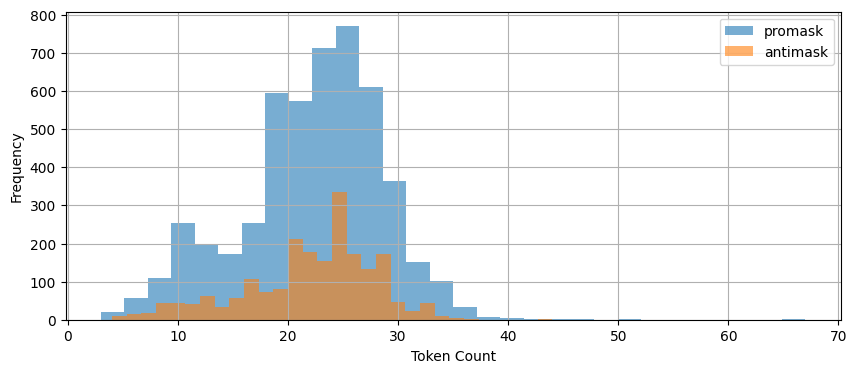

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
group,,,,,,,,,,,,
antimask,2069.0,21.899952,5.977403,4.0,6.0,10.0,19.0,23.0,26.0,30.0,33.0,44.0
promask,5000.0,22.209600,6.435336,3.0,7.0,10.0,18.0,23.0,27.0,31.0,35.0,67.0


In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
for grp in ['promask', 'antimask']: df[df.group==grp]['token_count'].hist(alpha=0.6, label=grp, bins=30, ax=ax)
ax.legend()
ax.set_xlabel('Token Count')
ax.set_ylabel('Frequency')
plt.show()

df.groupby('group')['token_count'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

The two groups skew similarly towards higher token counts.

It probably won't be practical to visualize all the words in our corpus, so let's start by showing the top 30 after filtering out stopwords, punctuation, numbers, and spaces.




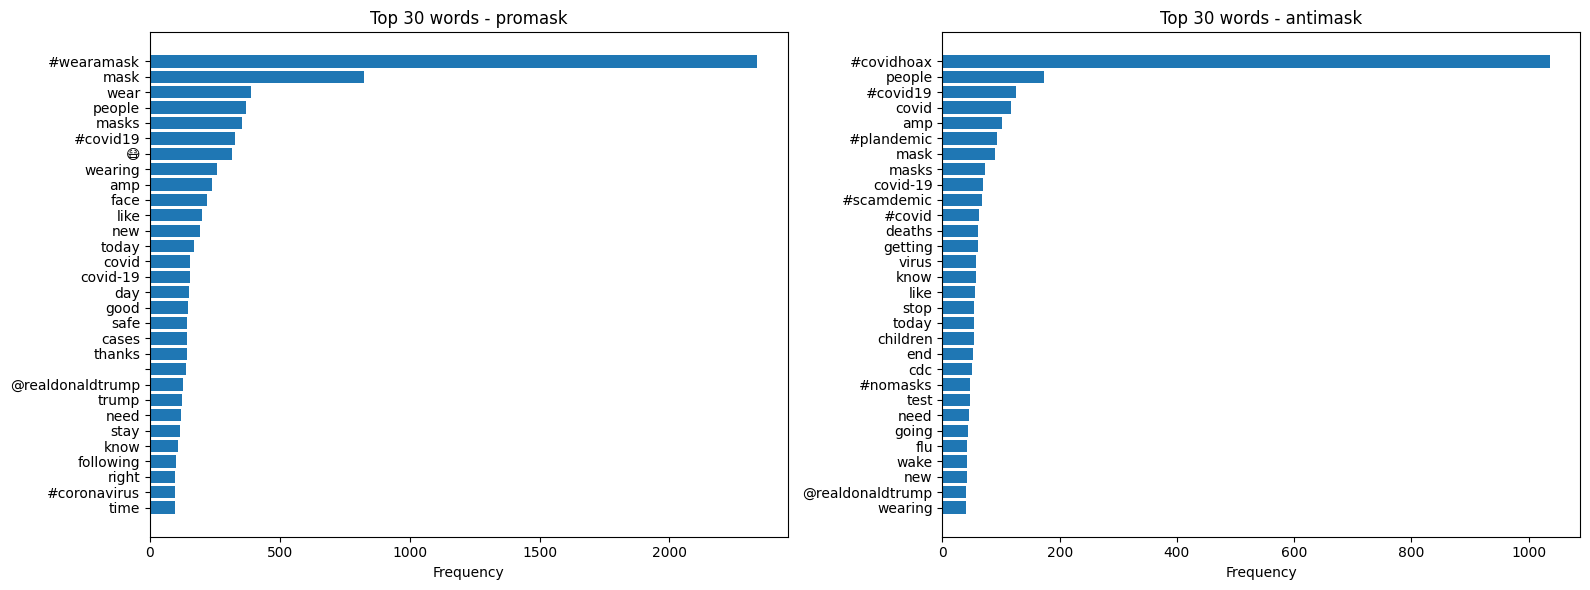

In [ ]:
num_to_plot = 30

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, group in zip(axes, ['promask', 'antimask']):
    word_counts = Counter()
    for text in df[df['group'] == group]['clean_text']:
        doc = nlp(text)
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.like_num and not token.is_space:
                word_counts[token.text] += 1
    
    top_words = word_counts.most_common(num_to_plot)
    words, counts = zip(*top_words)
    
    ax.barh(words[::-1], counts[::-1])
    ax.set_xlabel('Frequency')
    ax.set_title(f'Top {num_to_plot} words - {group}')

plt.tight_layout()
plt.show()

Another kind of "word" you could look at are emojis. I've stubbed in an example below... what else could you examine?

In [ ]:
emoji_pattern = re.compile(r'[\U0001F300-\U0001F9FF]')

def get_emoji(text):
    return emoji_pattern.findall(text)

for group in ['promask', 'antimask']:
    emojis = df[df['group'] == group]['clean_text'].apply(get_emoji).explode()
    print(f"\n{group} top emoji:")
    print(emojis.value_counts().head(10))



promask top emoji:
clean_text
😷    317
🏻     46
👇     43
🙏     35
🏾     33
🤣     31
😂     30
💜     28
🏼     26
👏     25
Name: count, dtype: int64

antimask top emoji:
clean_text
👇    35
💥    27
😂    22
🤣    20
👏    20
🤬    15
🚨    13
🏻    13
🏼    11
🤔     8
Name: count, dtype: int64


#### Keyword-in-Context

The function below is known as a **"keyword in context" (kwic)** visualization, or **concordance**. 

It works in three steps:
- Loop through texts — For each tweet, create a spaCy Doc
- Find matches — Loop through tokens, check if each matches the keyword (case-insensitive)
- Extract context — When a match is found, grab window tokens before and after

The key is getting the context window so your keyword is lined up nicely with token context:

```doc[max(0, i-window):i]``` — slice of tokens before the match (using max(0,...) to avoid negative indices)

```doc[i+1:i+1+window]``` — slice of tokens after the match

The ```:>40``` in the f-string right-aligns the left context to 40 characters, so the keyword lines up nicely in a column.

We've got a weird "amp" in our list. This looks suspiciously like poorly handled html codes. Let's explore that hypothesis with a quick concordance(key word in context or kwic) view.

In [ ]:
def kwic_spacy(texts, keyword, window=5, n=20):
    results = []
    for text in texts:
        doc = nlp(text)
        for i, token in enumerate(doc):
            if token.text.lower() == keyword.lower():
                left = doc[max(0, i-window):i].text.replace('\n', ' ')
                right = doc[i+1:i+1+window].text.replace('\n', ' ')
                results.append(f"{left:>40} [{token.text}] {right}")
                if len(results) >= n:
                    return results
    return results

for line in kwic_spacy(df['tweet_text'], 'amp', window=6, n=20):
    print(line)

            you ordered your Semper Fi & [amp] ; America's Fund face cover
                         On now. Darcy & [amp] ; stacey. #darceyandstacey #WearAMask https://t.co/YiUHzDQ2fh
                mask does not fit well & [amp] ; too much… https://t.co/OUmPor5R0K
  #LadyGaga , #StaySafe #SpeakYourMind & [amp] ; #WearAMask 😷 https://t.co/Ml01HRIkiZ
    Latest: 25,378,371 confirmed cases & [amp] ; 850,163 deaths 90 countries
                          If @ladygaga & [amp] ; her team can completely slay
                 now Tweeps. Take care & [amp] ; stay safe! #WearAMask
           Good to see @USEmbassyNepal & [amp] ; @USAmbNepal promoting #WearAMask &amp
 amp; @USAmbNepal promoting #WearAMask & [amp] ; #MaskChallenge even when Trump refuses
        . Greg Armstrong, Epidemiology & [amp] ; Cancer Control.  Learn
                         Ariana Grande & [amp] ; Lady Gaga  💜💜
          rallying all over the states & [amp] ; continuing to spread… https://t.co/uFLPOaMezt
                

## B - Distributional Patterns

Frequency alone is inadequate for revealing patterns of use. Let's look for high-frequency, low-dispersion terms. For example, a small number of users in our Twitter data could be responsible for boosting the frequency of specific terms. These could matter since they might reveal:
- Bot activity
- Coordinated messaging campaigns
- Copy-paste patterns
- Influential user amplification
Distributional analysis is important because it gets at "patterns of use" rather than isolated metrics.


Let's look at hashtags. We can plot in a variety of ways, though for our purposes it would be fun to compare between groups.

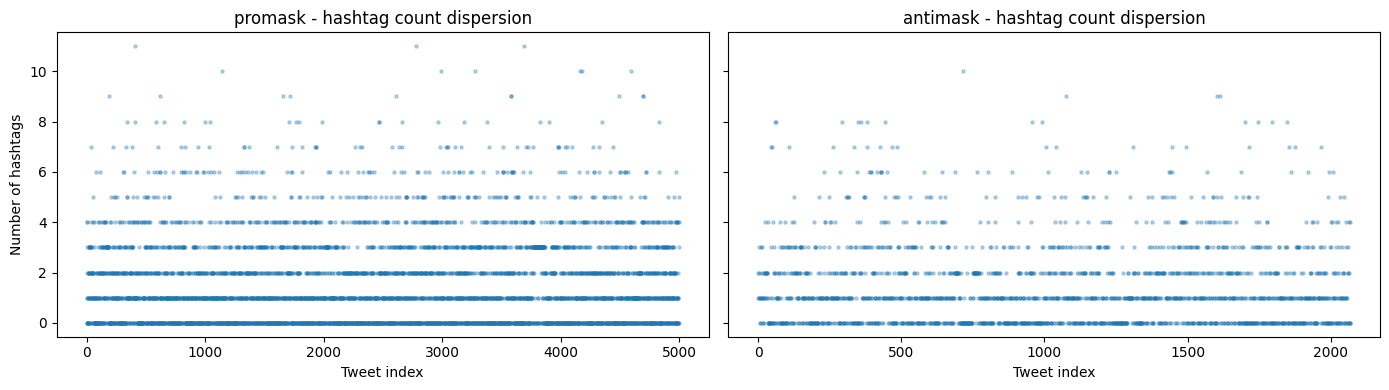

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for ax, group in zip(axes, ['promask', 'antimask']):
    subset = df[df['group'] == group].reset_index()
    ax.scatter(subset.index, subset['num_hashtags'], alpha=0.3, s=5)
    ax.set_xlabel('Tweet index')
    ax.set_title(f'{group} - hashtag count dispersion')

axes[0].set_ylabel('Number of hashtags')
plt.tight_layout()
plt.show()

It looks like it's common to have up to about 4 hashtags. What do samples containing 8 more more look like?

In [ ]:
# Let's expand our display so we can see the entire tweet text
pd.set_option('display.max_colwidth', None)

In [ ]:
df[df['num_hashtags'] >= 8][['group', 'num_hashtags', 'tweet_text']].groupby('group').head(5)

,group,num_hashtags,tweet_text
193,promask,9,#startup #healthcare #stayhome #staysafe #hopeforthebest #wearamask #washyourhands #protectyourself #protectothers… https://t.co/DGOFzacYD4
342,promask,8,#sundayinspiration got mask? \n.\n.\n.\n#gotmask #covid19nyc #covidharlem #pandemic #itsnotover #staysafer #wearamask… https://t.co/Wr24AO2sqq
405,promask,8,#Calling all #CoastlineCollege #students! Want a chance to #WIN #free #staycation #swag? Send us a #selfie wearing… https://t.co/bwDWdu2Eiq
408,promask,11,#quote #quoteoftheday #quotetoliveby #monday #inaworld #world #beanything #anything #bekind #kind #kindness… https://t.co/FRokelPXFL
588,promask,8,Mask up Washington 😷 \n.\n.\n.\n#maskup #maskupwashington #wearamask #wearyourmask #mask #selfie #maskselfie #hike… https://t.co/kv5QVJX4cp
5061,antimask,8,Wahoo go #Auckland #NewZealand liberty March protest #soProud #standUp #RedPill #kiwis #nzpol #NZHellhole… https://t.co/HCKcYcmouV
5062,antimask,8,Wahoo go #Auckland #NewZealand liberty March protest #soProud #standUp #RedPill #kiwis #nzpol #NZHellhole… https://t.co/dWBo8JS3jR
5293,antimask,8,SAVE OUR NHS OR IS IT TOO LATE? #Plandemic #Scamdemic #Pandemic #Endlockdown #CovidHoax #Awake #Freedom #Awake… https://t.co/sp7xEbk5v7
5350,antimask,8,David icke pt.3 #TrafalgarSquare #Nolockdown #covidhoax #KBF #NoMasks #Saynotomasks #londonprotest #uniteforfreedom… https://t.co/rUUCvofQHy
5358,antimask,8,#KeepBritainFree #KBF #uniteforfreedom #covidhoax #plandemic #scamdemic2020 #scamdemic @ScottAnd67 #standupx brill… https://t.co/MOcYThaxyo


These still link to X (Twitter). Can you look at some and guess which are real people and which aren't?

Let's play around with dispersions on other sorts of words!

In [ ]:
# list some of the words we want to examine

pandemic_words =   ["pandemic", "CDC", "cure", "science", "vaccine", "virus", "guidelines", "mask", "masks", "FDA"]
conspiracy_words = ["plandemic", "scamdemic", "hoax"]
search_words = pandemic_words
moral_words = ["like", "love", "adore", "dislike", "hate", "abhor", "detest", "sickening"]
some_stopwords = ["for","a", "the", "and"]

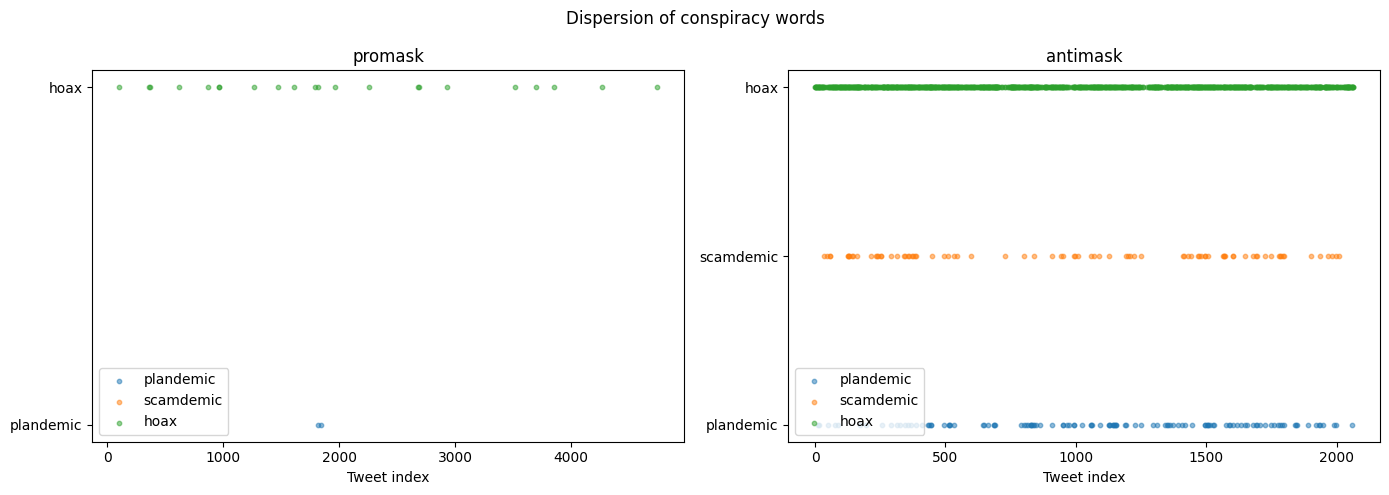

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, group in zip(axes, ['promask', 'antimask']):
    subset = df[df['group'] == group]['clean_text'].reset_index(drop=True)
    for word in conspiracy_words:
        positions = [i for i, text in enumerate(subset) if word.lower() in text.lower()]
        ax.scatter(positions, [word]*len(positions), alpha=0.5, s=10, label=word)
    ax.set_xlabel('Tweet index')
    ax.set_title(f'{group}')
    ax.legend()

plt.suptitle('Dispersion of conspiracy words')
plt.tight_layout()
plt.show()

Try some yourself!

## Bonus - Word Association Patterns

Before we move on to playing with other spaCy pipeline capabilities on this data, let's look at the utility of word associations to reveal patterns in data. These techniques are used in corpus statistics used to reveal patterns in language. Very similar statistical methods are used to build word embeddings, which we'll explore soon. Embeddings are a key tool for LLMs. 

What I hope you draw from this is that we have more tools at our disposal for looking at patterns in language data when it comes to squishy questions around the **social use** of language such as attitude, opinion, ideology, power, etc. If statistics excites you, this is an interesting area of study in linguistics.



At the heart of of corpus linguistics is quantitative methodology around the co-occurence and frequencies of words and word patterns. A basic tool for looking at co-occurence patterns is via bigrams. We can look at the liklihood of association of tokens or words. To do this, we'll need to dip into statistical tests to see if associations are more more than we'd expect by chance.


### Keywords

If you think about it, keywords are a way of finding words that are more frequent in one corpus than another. What distinguishes one text from another?

A keyword list is calculated by comparing 2 frequency lists together – usually a much larger **reference corpus** against a smaller specialised corpus (but sometimes 2 equal sized corpora). We're looking for words that are more frequent in one list when compared to the other. Given we don't have a reference corpus in this lab, we'll compare our two small datasets. 

We use inferential statistics such as chi-square or log-likelihood test identify the words that are statistically much more frequent in one list when compared to the other. 

We also have to decide when is a word should be considered a keyword. To do this, we apply cut-off points for statistical
significance. Or you could set an arbitrary cutoff such as look at the top 10 or 20 words (tokens) instead.

Additionally, sometimes a minimum frequency is applied (e.g. a word must occur 20 times before it’s a keyword). Just because a word is rare is not necessarily a keyword. We'll look at an example below.

Also, we may specify a keyword has to be reasonably well-distributed (occurring in at least 20 texts, for example).

Common types of keywords:

1. Proper nouns (Clegg, Ghana etc)
2. Markers of style (often grammatical words like must, betwixt)
3. Spelling idiosyncrasies (color/colour)
4. “Aboutness” words (politics, recipe etc) 

What’s the point of this...

Keywords identify **salient** words in a corpus, acting as **signposts** for a linguistic, cultural or discursive analysis Exploring why they’re there and what they do can lead to interesting questions. 

Humans have cognitive biases when it comes to noticing frequencies. Thus, se use statistical methods that are reproducible, and have high reliability/validity from a scientific perspective. 

We're going to use **log-liklihood** for comparing frequencies across corpora. This is an important method for comparing **observed vs. expected frequencies**.

Here's the approach:

1. Count word frequencies in each corpus
2. Calculate expected frequencies based on corpus sizes
3. Compute log-likelihood (G²) for each word
4. Rank by G² to find words significantly more frequent in one corpus

In [ ]:
# Get word frequencies

# I played around with removing things we're less interested in for this analysis such as punctuation and spaces. Freel free to do so, as well! When you filter out text like this, you must report that you did so. There will be an effect on your statistics.

# Can you think of reasons to include these sorts of things? One excellent things about spaCy is that it keeps track of spaces. We'll look at an NLP use case where this can matter.

def get_word_freqs(texts):
    freqs = Counter()
    for text in texts:
        doc = nlp(text)
        for tok in doc:
            if not tok.is_punct and not tok.is_space:
                freqs[tok.text.lower()] += 1
    return freqs

promask_freqs = get_word_freqs(df[df['group']=='promask']['clean_text'])
antimask_freqs = get_word_freqs(df[df['group']=='antimask']['clean_text'])

In [ ]:
# Get totalstotal_promask = sum(promask_freqs.values())total_antimask = sum(antimask_freqs.values())# Let's compare by frequency by normalizing per 1000 tokensnorm_promask = {w: (f / total_promask) * 1000 for w, f in promask_freqs.items()}norm_antimask = {w: (f / total_antimask) * 1000 for w, f in antimask_freqs.items()}norm_promask, norm_antimask

({'#2020sucks': 0.011560827292801074,
  '#trumpisscar': 0.011560827292801074,
  '#ihateithere': 0.011560827292801074,
  '#wearamask': 27.02921421056891,
  'black': 0.4624330917120429,
  'in': 11.08683337379623,
  'america': 0.6127238465184568,
  'https://t.co/0xjhtodsho': 0.011560827292801074,
  'this': 8.057896623082348,
  'is': 10.867177655233009,
  'probably': 0.19653406397761825,
  'one': 2.1849963583394025,
  'of': 11.768922184071492,
  'the': 24.65924461554469,
  'most': 0.5317980554688494,
  'ridiculous': 0.05780413646400536,
  'all': 4.635891744413231,
  '#antimasker': 0.03468248187840322,
  '#antimasking': 0.02312165458560215,
  'excuses': 0.011560827292801074,
  'ever': 0.3352639914912311,
  'recorded': 0.08092579104960751,
  '#doj': 0.011560827292801074,
  '#pandemic': 0.32370316419843004,
  'https://t.co/lq53brjvfi': 0.011560827292801074,
  'just': 2.982693441542677,
  'like': 2.3237262858530157,
  'do': 5.3295413819812945,
  'it': 8.809350397114418,
  '#maskuphoosiers': 0.

The log-likelihood formula uses a 2x2 contingency table for each word:

|                  | Corpus 1 | Corpus 2 | Total        |
|------------------|----------|----------|--------------|
| Word X present   | a        | b        | a + b        |
| Word X absent    | c − a    | d − b    | c + d − a − b|
| **Column totals**| **c**    | **d**    | **c + d**    |



The G² statistic is:

$$G^2 = 2 \left(
a \ln\frac{a(c+d)}{c(a+b)} \;+\;
b \ln\frac{b(c+d)}{d(a+b)}
\right)$$


G² = 2 * Σ(O * ln(O/E))
where O = observed, E = expected based on overall proportions.

The idea is that for any observation (word), we want to know whether it's more frequent than we'd expect by chance. 

Some things to look at:

- We need to work with normalized frequencies.
- If we were using this for more than this sample EDA, we'd be reporting efffect size.
- Low, and rare counts are potentially an issue.
- Dispersion measures are also important. We could look at the number of tweets in which a word appears. 



In [ ]:
def log_likelihood(a, b, c, d):
    """Calculate G² for a 2x2 contingency table."""
    n = a + b + c + d
    e1 = (a + b) * (a + c) / n
    e2 = (a + b) * (b + d) / n
    
    def safe_log(o, e):
        return o * math.log(o / e) if o > 0 else 0
    
    return 2 * (safe_log(a, e1) + safe_log(b, e2) + 
                safe_log(c, (a+c)*(c+d)/n) + safe_log(d, (b+d)*(c+d)/n))

# Get totals
total_promask = sum(promask_freqs.values())
total_antimask = sum(antimask_freqs.values())

# Get all words
all_words = set(promask_freqs.keys()) | set(antimask_freqs.keys())

# Calculate G² for each word
results = []
for word in all_words:
    a = promask_freqs.get(word, 0)
    b = antimask_freqs.get(word, 0)
    c = total_promask - a
    d = total_antimask - b
    g2 = log_likelihood(a, b, c, d)
    # Positive = more in promask, negative = more in antimask
    direction = 'promask' if a/total_promask > b/total_antimask else 'antimask'
    results.append((word, g2, direction, a, b))

# Sort by G² and show top keywords for each group
results.sort(key=lambda x: x[1], reverse=True)

In [ ]:
results

[('#covidhoax', 2562.0193812980156, 'antimask', 1, 1036),
 ('#wearamask', 1569.4418227011088, 'promask', 2338, 5),
 ('😷', 218.64480244884155, 'promask', 317, 0),
 ('#plandemic', 211.55555799251485, 'antimask', 2, 93),
 ('mask', 203.6027536225049, 'promask', 826, 90),
 ('the', 188.55280753118302, 'antimask', 2133, 1408),
 ('#scamdemic', 165.3628409836379, 'antimask', 0, 67),
 ('wear', 126.77271544263905, 'promask', 390, 30),
 ('#nomasks', 100.64590639777374, 'antimask', 2, 47),
 ('is', 97.02974293350962, 'antimask', 940, 644),
 ('#notomasks', 91.29762506443217, 'antimask', 0, 37),
 ('hugging', 78.95691632260124, 'antimask', 0, 32),
 ('83', 74.02091221347692, 'antimask', 0, 30),
 ('safe', 72.31683506544091, 'promask', 144, 4),
 ('cdc', 70.19708335226802, 'antimask', 13, 51),
 ('children', 67.06723026643739, 'antimask', 16, 53),
 ('@skynews', 66.61720535739643, 'antimask', 0, 27),
 ('💥', 66.61720535739643, 'antimask', 0, 27),
 ('face', 65.81115515356701, 'promask', 220, 19),
 ('they', 65.

No huge surprises towards the top of this list, but it's nice to see that we have a few words that are more frequent in one corpus than the other. 

#covidhoax (G²=2562) — massively more frequent in antimask tweets
#wearamask (G²=1569) — massively more frequent in promask tweets

Browse through a few more to see if you are surprised by what surfaces!

### Collocations

With keywords, we were comparing a term against other terms  in use. Let's shift to looking at the co-occurence of words. The simplest way to do this is to look at bigrams. 

Bigrams in our context are pairs of words or tokens. Here's an example below. We'll need to use bigrams and unigrams (single word/token frequencies) for some of the statistics below.

In [ ]:
doc = nlp("I love wearing masks")
bigrams = [(doc[i].text, doc[i+1].text) for i in range(len(doc)-1)]
print(bigrams)

[('I', 'love'), ('love', 'wearing'), ('wearing', 'masks')]


**Collocations** are sequences of words that co-occur unusually frequently and that over time start to take on a meaning or a salience that resists the token sequence being broken down into its individual parts. 

Often words that start off as collocations become increasingly fixed as lexical items, especially when they are used with great frequency. This process is called **lexicalization**. 

For example, as noun-noun collocations such as 'ice chest', 'data base' or 'war game' become increasingly cemented in the vocabulary of English, even native speakers pause to wonder 'Does ice-chest have a hyphen? Is database all one word? **That is a sign of the increasing lexicalization of the collocation.**

In some cases, you can introspect about whether a collocation has a non-compositional meaning by trying to substitute it with a single synonym, such as 'cooler' for 'icechest' or 'assassin' for 'hit man' (or is that hitman?) Collocations can consist of numerous combinations of parts-of-speech, but most have in common the somewhat idiosyncratic nature of their meaning, which can exhibit differing degrees of compositionality. 

This is a challenge for second language learners, and websites such as 7esl devote some effort to helping people master them. For the purposes of natural language processing, when setting out to answer an analytic question with natural language data, it is important to consider whether and to what degree identifying collocations is relevant and necessary. How you treat collocations can affect everything from first order frequency counts to the quality of word embeddings, which are so widely used in contemporary machine learning.

**n-grams** (also written **ngrams**), are collcations. We'll talk about this term many times throughout the course, because n-grams are so central to language modeling in NLP. The n in n-gram is meant to represent a variable of any length. The gram in n-gram is a graphical representation of some chunk of language, which might be characters, morphemes, tokens, or words. Some of the shorter n-grams have special names, such as bigram or trigram, which are 2-grams and 3-grams, respectively.

Collocation measures of words are a kind of **association measure** that calculates the strength of association between words. There are many different association measures, but they all work on the same basic principle: they compare the observed frequency of a pair of words with the expected.


Useful to data scientists are the collocation graphs. Collocation graphs visually map which words commonly appear together in language. By treating words as nodes and their relationships as edges, they help us see patterns of meaning, usage, and discourse structure.

![](images/collocation-graph.png)


For collocation analysis (word associations within a corpus), these are fairly typical statistics that we can use. Let's look at PMI and t-score further.

**PMI (Pointwise Mutual Information)** — how much more likely words co-occur than by chance
**t-score** — favors frequent combinations over rare
**Log-Dice** — normalized, easier to interpret across corpora
**Log-likelihood** tells you if a difference is significant; effect size measures tell you how big the difference is. Often you want both.

In [ ]:
# I've filtered bigrams here so that we focus more on content words. You could filter further.

def count_bigrams_filtered(tweets):
    bigram_counts = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        for i in range(len(doc)-1):
            t1, t2 = doc[i], doc[i+1]
            # Keep if at least one token is a content word
            if not ((t1.is_stop or t1.is_punct or t1.is_space) and 
                    (t2.is_stop or t2.is_punct or t2.is_space)):
                bigram_counts[(t1.text, t2.text)] += 1
    return bigram_counts

bigrams_promask = count_bigrams_filtered(df[df['group'] == 'promask']['clean_text'])
bigrams_antimask = count_bigrams_filtered(df[df['group'] == 'antimask']['clean_text'])

In [ ]:
list(bigrams_promask.items())[:10]

[(('#2020sucks', '#trumpisscar'), 1),
 (('#trumpisscar', '#ihateithere'), 1),
 (('#ihateithere', '#wearamask'), 1),
 (('#wearamask', '@'), 9),
 (('@', 'black'), 1),
 (('black', 'in'), 1),
 (('in', 'america'), 5),
 (('america', 'https://t.co/0xjhtodsho'), 1),
 (('is', 'probably'), 3),
 (('probably', 'one'), 1)]

In [ ]:
# We need unigrams for PMI, as well.

def count_unigrams(tweets):
    unigram_counts = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        for tok in doc:
            if not tok.is_punct and not tok.is_space:
                unigram_counts[tok.text] += 1
    return unigram_counts

In [ ]:
def calculate_pmi(bigram_counts, unigram_counts, min_freq=5):
    N = sum(bigram_counts.values())
    results = []
    for (w1, w2), count in bigram_counts.items():
        if count >= min_freq and w1 in unigram_counts and w2 in unigram_counts:
            pmi = math.log2((count * N) / (unigram_counts[w1] * unigram_counts[w2]))
            results.append(((w1, w2), pmi, count))
    return sorted(results, key=lambda x: x[1], reverse=True)

# Calculate for pro-mask... do anti-mask on your own.
unigrams_promask = count_unigrams(df[df['group'] == 'promask']['clean_text'])
pmi_promask = calculate_pmi(bigrams_promask, unigrams_promask, min_freq=5)

pmi_promask[:20]

[(('@smallstreamersc', '@smallstreamersr'), 13.854809957602006, 5),
 (('@mmittelbrunn', '@xrbustelo'), 13.854809957602006, 5),
 (('@madelpozo67', '@astro_duque'), 13.854809957602006, 5),
 (('@astro_duque', '@raquelyotti'), 13.854809957602006, 5),
 (('@raquelyotti', '@rafaelgaresse'), 13.854809957602006, 5),
 (('#actnowhonolulu', '#nosocialgathering'), 13.854809957602006, 5),
 (('#nosocialgathering', '#actwithcare'), 13.854809957602006, 5),
 (('#actwithcare', '#donotgather'), 13.854809957602006, 5),
 (('david', 'icke'), 13.591775551768212, 5),
 (('@sir_ruffy', '@fresh4lyf'), 13.591775551768212, 5),
 (('@the_afrocentric', '@wordsworthgwary'), 13.591775551768212, 5),
 (('@fresh4lyf', '@aburaees66'), 13.369383130431764, 6),
 (('notre', 'dame'), 13.369383130431764, 7),
 (('📷', '#actnowhonolulu'), 13.369383130431764, 5),
 (('@ashiruadamua', '@binzaranda'), 13.328741145934417, 5),
 (('🇨', '🇦'), 13.176738052489368, 7),
 (('ariana', 'grande'), 13.10634872459797, 5),
 (('🙅', '🏾\u200d'), 13.10634

Some of these make sense... and some don't. Like '@smallstreamersc', '@smallstreamersr'. 

The high PMI for ('@smallstreamersc', '@smallstreamersr') illustrates exactly a weakness of PMI. These two words only appear 5 times each, and always together. PMI rewards that perfect co-occurrence, even though it's just one user's tagging pattern, not a meaningful collocation.

To find the original tweets, you can filter the dataframe:

df[df['clean_text'].str.contains('@smallstreamersc', case=False)]['tweet_text']

Or use the kwic_spacy function we built earlier for context.

To get more meaningful collocations, we could:

- Raise the frequency threshold (e.g., min_freq=10 or 20)
- Filter out more before counting
- Use t-score instead — it favors more frequent combinations

In [ ]:
def calculate_tscore(bigram_counts, unigram_counts, min_freq=5):
    N = sum(bigram_counts.values())
    results = []
    for (w1, w2), observed in bigram_counts.items():
        if observed >= min_freq and w1 in unigram_counts and w2 in unigram_counts:
            expected = (unigram_counts[w1] * unigram_counts[w2]) / N
            tscore = (observed - expected) / math.sqrt(observed)
            results.append(((w1, w2), tscore, observed))
    return sorted(results, key=lambda x: x[1], reverse=True)

tscore_promask = calculate_tscore(bigrams_promask, unigrams_promask, min_freq=5)
tscore_promask[:20]

[(('a', 'mask'), 18.132246137664676, 367),
 (('wear', 'a'), 14.960367527889547, 242),
 (('wearing', 'a'), 11.223213536700527, 138),
 (('face', 'mask'), 10.58986251541814, 117),
 (('thanks', 'for'), 9.791094215930617, 99),
 (('#writingcommunity', '#stayathomesavelives'), 9.15400438751346, 84),
 (('for', 'following'), 8.987447583772669, 83),
 (('#stayathomesavelives', '#wearamask'), 8.92513611669674, 85),
 (('to', 'wear'), 8.924417506547904, 99),
 (('thank', 'you'), 8.804089401426875, 80),
 (('#wearamask', '😷'), 8.314286855823438, 88),
 (('need', 'to'), 8.115295294365053, 72),
 (('stay', 'safe'), 7.845863725560401, 62),
 (('😷', '😷'), 7.766344960421186, 63),
 (('following', '#writingcommunity'), 7.332303234603918, 54),
 (('of', '#covid19'), 6.514097204375823, 51),
 (('wear', 'masks'), 6.351487052147337, 44),
 (('the', 'spread'), 6.338067463029622, 44),
 (('wearing', 'masks'), 6.289218073135986, 42),
 (('#wearamask', '#wearadamnmask'), 6.23014621082064, 43)]

These look more interesting and give us more insight than unigrams alone!

Lest you think we must rely on NLP tools for studying study language use - here are a couple of examples now accessible to you (based on our discussion of frequencies, keywords, and collocates) that highlight how we can use statistical methods to study language use.

1. Islentyeva (2023) — [British Media Representations of EU Migrants](https://www.lancaster.ac.uk/fass/journals/cadaad/wp-content/uploads/2023/06/Islentyeva.pdf?utm_source=chatgpt.com)

A corpus-assisted analysis of two specialised corpora (500 articles each) across mainstream British newspapers before and after the Brexit referendum.

It traces linguistic patterns and ideological bias in how European migrants were discussed, noting differences between left- and right-leaning outlet

2. Gabrielatos & Baker et al. (2006/2007) — [Tabloids vs. Broadsheets on Immigration](https://www.researchgate.net/publication/261708737_Representation_of_refugees_and_asylum_seekers_in_UK_newspapers_Towards_a_corpus-based_comparison_of_the_stance_of_tabloids_and_broadsheets)

Work presented at CADAAD 2006 and in later publications explores how refugees, asylum seekers, and immigrants are framed in UK newspapers, with a focus on contrasting broadsheets vs. tabloids.

The project uses collocation and frequency analysis within a corpus framework to quantify differences in stance and lexical choices.


## C - Parts-of-Speech Patterns

The POS tagger was not trained on twitter data. So we will not find much value here.

POS can be useful is finding ways to look at things like:
- NOUN density. How much is information-heavy vs opinion-heavy
- ADJ frequency. Evaluative language
- PRON patterns. Personal involvement

I will try looking at noun chunks and also modal verbs. Exploring patterns via POS could give you interesting ideas when you start thinking about other corpora.

In [ ]:
def get_pos_distribution(tweets):
    pos_counts = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        pos_counts.update([t.pos_ for t in doc if not t.is_punct])
        total = sum(pos_counts.values()) 
    return {pos: count/total for pos, count in pos_counts.items()}

In [ ]:
pos_dist_promask = get_pos_distribution(df[df['group'] == 'promask']['clean_text'])
pos_dist_antimask = get_pos_distribution(df[df['group'] == 'antimask']['clean_text'])


In [ ]:
pos_dist_promask, pos_dist_antimask

({'NOUN': 0.21898971211984478,
  'PROPN': 0.14881328399963903,
  'ADP': 0.07586183557440664,
  'PRON': 0.08803357097734861,
  'AUX': 0.05283819149896219,
  'ADV': 0.03975272989802364,
  'NUM': 0.02195198989260897,
  'DET': 0.057993412146918145,
  'ADJ': 0.06355473332731702,
  'VERB': 0.12599269019041603,
  'INTJ': 0.005064976085190867,
  'SCONJ': 0.018161718256475046,
  'PART': 0.028336792708239328,
  'CCONJ': 0.02015837920765274,
  'PUNCT': 0.0026847757422615286,
  'SPACE': 0.024241945672773216,
  'X': 0.006486327948741088,
  'SYM': 0.0010829347531811208},
 {'NUM': 0.016609110343693473,
  'ADP': 0.07789289042372417,
  'DET': 0.07060242284711944,
  'PROPN': 0.12418461875787973,
  'NOUN': 0.20988872444225182,
  'AUX': 0.0656416159622869,
  'ADV': 0.045853203968645506,
  'PRON': 0.08902044619854191,
  'VERB': 0.12903579455133476,
  'ADJ': 0.06819053883681413,
  'SPACE': 0.025516636518116538,
  'SCONJ': 0.020172120813462698,
  'PART': 0.025242558789672753,
  'CCONJ': 0.017157265800581044,

Do you see any interesting differences?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠

A few patterns stand out:

1. **PROPN (proper nouns)** — promask 14.9% vs antimask 12.4%. Promask tweets mention more named entities (people, places, organizations)

2. **DET (determiners)** — antimask 7.1% vs promask 5.8%. More "the", "a", "this" suggests more declarative statements

3. **AUX (auxiliaries)** — antimask 6.6% vs promask 5.3%. More auxiliary verbs ("is", "are", "will") could indicate more assertive/argumentative language

4. **ADJ (adjectives)** — antimask 6.8% vs promask 6.4%. Slightly more evaluative language in antimask

5. **SYM (symbols)** — promask uses twice as many (0.11% vs 0.05%). Probably more emoji usage (like 😷)

The higher PROPN in promask is interesting — want to dig into what entities they're mentioning? We could look at the actual proper nouns each group uses.

Let's look at noun phrases, and modal verbs.

In [ ]:
def get_noun_chunk_counts(tweets, min_words=2):
    chunk_counts = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        for chunk in doc.noun_chunks:
            # Skip single pronouns
            if len(chunk) >= min_words:
                chunk_counts[chunk.text.lower()] += 1
    return chunk_counts

chunks_promask = get_noun_chunk_counts(df[df['group'] == 'promask']['clean_text'])
chunks_antimask = get_noun_chunk_counts(df[df['group'] == 'antimask']['clean_text'])



In [ ]:
chunks_promask.most_common(20), chunks_antimask.most_common(20)

([('a mask', 339),
  ('the spread', 44),
  ('your mask', 35),
  ('family masks', 35),
  ('the virus', 32),
  ('the world', 25),
  ('these people', 18),
  ('no one', 18),
  ('a face mask', 18),
  ('a lot', 18),
  ('#wearamask 😷', 18),
  ('the mask', 17),
  ('our channel', 17),
  ('the way', 16),
  ('social distancing', 16),
  ('that graph', 15),
  ('the follow', 14),
  ('your nose', 14),
  ('my mask', 13),
  ('a message', 13)],
 [('the #covidhoax', 90),
  ('a mask', 36),
  ('your children', 32),
  ('only 6%', 21),
  ('the cdc', 20),
  ('the belgian newspaper', 18),
  ('average age', 18),
  ('the world', 17),
  ('the truth', 17),
  ('the people', 17),
  ('bc canada', 16),
  ('the virus', 14),
  ('a hoax', 13),
  ('no evid', 13),
  ('all entities', 12),
  ('a #covidhoax', 11),
  ('a virus', 11),
  ('quarantine camps', 11),
  ('6%', 10),
  ('all those', 10)])

Let's look at the frequency of modal verbs. Modal verbs express modality, which is a category of meaning that expresses the speaker's attitude toward the action or state expressed.

We'll look at several types of modality:
- Strong obligation: must, need to
- Weaker obligation: should, ought to 
- Prohibition: can't, must not, shouldn't

We could also consider imperative verbs (e.g., "wear", "stop", "wake up") — they're prescriptive too.



In [ ]:
modals = {
    'strong': ['must', 'need', 'have'],  # "have to" needs special handling
    'medium': ['should', 'ought'],
    'weak': ['can', 'could', 'may', 'might']
}

In [ ]:
# build reverse lookup once
modal_to_strength = {
    word: strength
    for strength, words in modals.items()
    for word in words
}

def get_modal_counts(tweets):
    modal_counts = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        for tok in doc:
            word =  tok.text.lower()
            strength = modal_to_strength.get(word)
            if strength:
                modal_counts[strength] += 1
    return modal_counts




In [ ]:
modals_promask = get_modal_counts(df[df['group'] == 'promask']['clean_text'])
modals_antimask = get_modal_counts(df[df['group'] == 'antimask']['clean_text'])

In [ ]:

total_promask_tokens = df[df['group'] == 'promask']['token_count'].sum()
total_antimask_tokens = df[df['group'] == 'promask']['token_count'].sum()

# Normalized ate per 1000 tokens
# How about per tweets? What about the other modals?
modals_promask['strong'] / total_promask_tokens * 1000, modals_antimask['strong'] / total_antimask_tokens * 1000

(np.float64(5.033859232043801), np.float64(2.332324760463943))

## D - Lexical Variety Through Lemmatization

Let's lemmatize our tokens. It might be interesting to look at lemmas unique to each group and common to both groups.

You'll need to type in variable names to explore these. I've just added shared_lemmas, as an example. 

In [ ]:
def get_unique_lemmas(tweets):
    lemmas = set()
    for tweet in tweets:
        doc = nlp(tweet)
        for tok in doc:
            if not tok.is_punct and not tok.is_space and not tok.like_url:
                if tok.like_url: 
                    continue
                if tok.text.startswith('@'):  # mentions
                    continue
                lemmas.add(tok.lemma_.lower())
    return lemmas

In [ ]:
promask_texts = df[df['group'] == 'promask']['clean_text']
antimask_texts = df[df['group'] == 'antimask']['clean_text']

promask_lemmas = get_unique_lemmas(promask_texts)
antimask_lemmas = get_unique_lemmas(antimask_texts)
unique_to_promask_lemmas = promask_lemmas - antimask_lemmas
unique_to_antimask_lemmas = antimask_lemmas - promask_lemmas
shared_lemmas = promask_lemmas & antimask_lemmas

In [ ]:
shared_lemmas

{'water',
 'tactic',
 'genuinely',
 'impose',
 'disease',
 'emergency',
 'unable',
 'donation',
 'register',
 'inaccurate',
 'somebody',
 'well',
 'ultimate',
 'sign',
 'everything',
 '+',
 '#resistance',
 'racism',
 'cruel',
 'transport',
 'fan',
 'hmmm',
 '#surgery',
 'fault',
 'only',
 'shock',
 'nappy',
 'blake',
 'spite',
 'bio',
 'pregnant',
 'form',
 'healthcare',
 'yo',
 'demonstrator',
 'cheap',
 'shout',
 'definitely',
 'elsewhere',
 'spike',
 'despite',
 'july',
 'aka',
 'investigate',
 'deceive',
 'turn',
 'actually',
 'live',
 'mortality',
 'nice',
 'constituent',
 'widely',
 'fellow',
 'harm',
 '#climatechange',
 'educate',
 '🤔',
 'care',
 'folk',
 'link',
 'ra',
 'surprised',
 'ev',
 'normalcy',
 'work',
 'celebs',
 'ma',
 'reflect',
 '#secondwave',
 'metric',
 'rid',
 '23',
 '#nomaskonme',
 'panic',
 'actual',
 'chairman',
 'frog',
 'dream',
 'chance',
 'course',
 'code',
 'brilliant',
 '🥴',
 'struggle',
 'house',
 'iq',
 'rise',
 'y',
 'ch',
 'guard',
 'hoe',
 'mask',


## E - Named Entity Recognition

As with POS tagging, we don't expect these analytics to be particularly useful. The NER component was not trained on tweet text and will do poorly. Nonetheless, let's take a quick look so you are able to see how to use it.

Entity type distributions
 
Aggregate across corpus
- PERSON mentions (authorities, politicians, scientists)
- ORG mentions (CDC, WHO, government agencies)
- GPE (locations - local vs. national vs. international framing)
- DATE (temporal framing differences)

How well might we be able to detect people mentions?

How well might we be able to find interesting patterns of co-occurence of entities?
    - Which entities appear together in tweets?
    - Example: "Fauci" + "lie" vs. "Fauci" + "expert"
    - Simple co-occurrence matrix for top 10 entities

Later, we will talk about how must evaluate the quality of NER. For now, let's just practice using it.




In [ ]:
def get_entity_types(tweets):
    ent_counts = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        ent_counts.update([ent.label_ for ent in doc.ents])
    return ent_counts

ents_promask = get_entity_types(df[df['group'] == 'promask']['tweet_text'])
ents_antimask = get_entity_types(df[df['group'] == 'antimask']['tweet_text'])

ents_promask.most_common(10), ents_antimask.most_common(10)

([('ORG', 1701),
  ('PERSON', 1587),
  ('CARDINAL', 1017),
  ('GPE', 1008),
  ('DATE', 912),
  ('NORP', 245),
  ('TIME', 138),
  ('ORDINAL', 94),
  ('PRODUCT', 84),
  ('MONEY', 78)],
 [('ORG', 697),
  ('PERSON', 648),
  ('DATE', 277),
  ('GPE', 264),
  ('CARDINAL', 238),
  ('NORP', 154),
  ('PERCENT', 78),
  ('PRODUCT', 36),
  ('ORDINAL', 35),
  ('WORK_OF_ART', 19)])

In [ ]:
def get_entities_by_type(tweets, ent_type):
    ents = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        for ent in doc.ents:
            if ent.label_ == ent_type: ents[ent.text] += 1
    return ents


In [ ]:
get_entities_by_type(df[df['group']=='promask']['tweet_text'], 'ORG').most_common(20), get_entities_by_type(df[df['group']=='antimask']['tweet_text'], 'ORG').most_common(20)

([('😷', 153),
  ('Trump', 37),
  ('COVID-19', 28),
  ('@WHO', 15),
  ('CDC', 13),
  ('RNC', 11),
  ('#WearAMask &amp', 10),
  ('Walmart', 10),
  ('PPE', 8),
  ('#WearAMask', 8),
  ('@KTRTRS', 7),
  ('Challenge', 7),
  ('GOP', 6),
  ('COVID', 5),
  ('VOTE', 5),
  ('@MSNBC', 5),
  ('@MollyJongFast', 5),
  ('@Abdulrahmanleme @Omojuwa @YusufTAbubakar', 5),
  ('Etsy', 5),
  ('🙏', 5)],
 [('CDC', 46),
  ('BC Canada', 16),
  ('NHS', 10),
  ('NEVER', 9),
  ('Trump', 7),
  ('COVID-19', 7),
  ('MSM', 7),
  ('#Nebraska', 7),
  ('NFL', 6),
  ('RNC', 5),
  ('BS', 4),
  ('#CovidHoax &', 4),
  ('@MSNBC', 4),
  ('BBC', 4),
  ('NJ', 4),
  ('the W H O  wanna', 4),
  ('Fauci', 3),
  ('WTF', 3),
  ('NWO', 3),
  ('UN', 3)])

In [ ]:
def get_entity_cooccurrence(tweets, ent_type='PERSON', top_n=10):
    ent_counts = get_entities_by_type(tweets, ent_type)
    top_ents = [e for e, _ in ent_counts.most_common(top_n)]
    cooc = Counter()
    for tweet in tweets:
        doc = nlp(tweet)
        ents_in_tweet = [ent.text for ent in doc.ents if ent.label_ == ent_type and ent.text in top_ents]
        for i, e1 in enumerate(ents_in_tweet):
            for e2 in ents_in_tweet[i+1:]:
                pair = tuple(sorted([e1, e2]))
                cooc[pair] += 1
    return top_ents, cooc

top_promask, cooc_promask = get_entity_cooccurrence(df[df['group']=='promask']['tweet_text'])
top_antimask, cooc_antimask = get_entity_cooccurrence(df[df['group']=='antimask']['tweet_text'])

cooc_promask.most_common(10), cooc_antimask.most_common(10)

([(('😷', '😷'), 43),
  (('Karen', 'Karen'), 6),
  (('😷', '😷😷'), 5),
  (('COVID', 'COVID'), 1),
  (('COVID-19', 'COVID-19'), 1),
  (('COVID', 'Trump'), 1),
  (('#WearAMask', 'Trump'), 1),
  (('#COVID', 'COVID-19'), 1)],
 [(('Covid', 'Covid'), 1),
  (('#COVID1984', 'Trafalgar Square'), 1),
  (('#COVID', 'Biden'), 1)])

## F - Reflection 

1. What linguistic features most strongly distinguish these communities?

2. What aspects of variety were we able to detect using word frequency or spaCy rule-based and statistical methods? What might we be missing?

3. Based on this EDA, which tasks would benefit from corpus statistics methods vs. classical NLP (rules, POS tags, NER) vs. LLMs (ambiguity, context, nuance)?


In [12]:
q3_answer = "What language features most strongly distinguish these communities?"

In [14]:
q4_answer = "What aspects of variety were we able to detect with statistical methods or spaCy classical NLP methods? "

In [16]:
q5_answer = "What tasks might benefit from corpus statistics methods vs classical NLP methds vs. LLMs?"

## G - LLM Analysis

### G.1 - Hashtags

Hashtags are linguistically weird:
- No spaces: #CovidIsntReal
- Mixed case semantics: #wearAMask vs #WearAMask vs #WEARAMASK
- Compound meanings: #DoYourOwnResearch (literal + ideological signal)
- Emoji integration: #MaskUp😷 or #NoMasks🙅‍♂️
- Sarcasm markers: #TrustTheScience (could be genuine or mocking)

Could we create custom functions to break hashtags into words? With some effort and degree of error, yes. As it stands, spaCy treats hashtags as proper nouns, doesn't parse internal structure, and can't interpret emoji semantics. POS won't help us much... nor will NER or spaCy dependency parsing.

In [ ]:
doc = nlp("#DoYourOwnResearch 🐑 #WakeUp")
for token in doc:
    print(f"{token.text:20} {token.pos_:10} {token.lemma_}")


#DoYourOwnResearch   PROPN      #DoYourOwnResearch
🐑                    PROPN      🐑
#WakeUp              NUM        #wakeup


In [ ]:
tweets = [
    "#DoYourOwnResearch 🐑 #WakeUp Don't let them tell you what to think",
    
    "Proud to #WearAMask 😷 Protecting my community! #InThisTogether ❤️",
    
    "#TrustTheScience right into the grave 💀 #CovidHoax",
    
    "My freedoms > your fears 🇺🇸 #NoMasks #LiveFree or don't idc"
]

In [ ]:
def llm_analyze_tweet(text, model=models[0]):
    "Analyze tweet for hashtag semantics, ideological signals, and ambiguity"
    prompt = f"""Analyze this tweet for linguistic and social signals:

1. "#DoYourOwnResearch 🐑 #WakeUp Don't let them tell you what to think"
    
2. "Proud to #WearAMask 😷 Protecting my community! #InThisTogether ❤️"
    
3. "#TrustTheScience right into the grave 💀 #CovidHoax"
    
4. "My freedoms > your fears 🇺🇸 #NoMasks #LiveFree or don't idc"

For each hashtag, convey literal meaning, ideological signal, and whether it's sincere/ironic/ambiguous. Explain reasoning.
"""
    
    chat = Chat(model)
    response = chat(prompt)
    return response.choices[0].message.content

llm_analyze_tweet(tweets[0])

'# Analysis of Tweets\n\n## Tweet 1: "#DoYourOwnResearch 🐑 #WakeUp Don\'t let them tell you what to think"\n\n**#DoYourOwnResearch**\n- *Literal meaning:* Conduct independent investigation\n- *Ideological signal:* Anti-establishment, skepticism of mainstream sources/authorities\n- *Tone:* **Sincere** - Positioning self as independent thinker\n- *Reasoning:* Commonly used in conspiracy-adjacent communities; implies mainstream narratives are deceptive\n\n**#WakeUp**\n- *Literal meaning:* Become alert/aware\n- *Ideological signal:* Conspiracy theory rhetoric; suggests others are "asleep" to hidden truths\n- *Tone:* **Sincere**\n- *Reasoning:* Classic awakening metaphor used by those claiming special knowledge\n\n**🐑 (sheep emoji)**\n- *Literal meaning:* Sheep animal\n- *Ideological signal:* Calling others "sheeple" - followers who don\'t think critically\n- *Tone:* **Sincere contempt**\n- *Reasoning:* Derogatory term for perceived conformists; signals in-group/out-group thinking\n\n**Over

#### Reflection

1. What information did the LLM extract that spaCy's POS tags and lemmas couldn't capture?

2. How did the LLM 'know' that 🐑 is being used ironically here? Where does that knowledge come from?

3. The LLM recognizes '#DoYourOwnResearch' as ideologically loaded. How did it learn that association? Could we build that into a classical rule-based system?



In [19]:
q6_answer = "What information did LLMs infer that SpaCy's POS tags and lemmas couldn't?"

In [21]:
q7_answer = "How did the LLM know that 🐑 indicated irony?"

In [22]:
q8_answer = "How did the LLM recognizes an association of #DoYourOwnResearch to ideology?"

### G.2 Stance Detection

'Stance' indicates a position on a target (e.g., a topic). 

Stance isn't always explicit. People signal positions through:
- Sarcasm and irony
- Rhetorical questions
- Presupposition and framing
- Tone and affect


Let's look at tweet pairs that look superficially similar.


In [ ]:
def llm_analyze_tweet(model=models[0]):
    "Analyze stance and use of language and emoji"
    prompt = f"""Analyze this tweet for linguistic and social signals:
   
Tweet 1: , "Wow, masks really work 😂"

Tweet 2: "Science says masks work. Period."

Tweet 3: "Sure, trust the 'experts' 🙄"

Tweet 4: "Trust the experts. They know what they're doing."

For each tweet, determine:
1. Explicit stance (pro-mask, anti-mask, neutral)
2. Confidence level (high/medium/low)
3. Key linguistic cues that reveal stance
4. Any irony, sarcasm, or non-literal language
5. How emoji/punctuation modifies meaning"""
    
    chat = Chat(model)
    response = chat(prompt)
    return response.choices[0].message.content

llm_analyze_tweet()




'# Linguistic and Social Signal Analysis\n\n## Tweet 1: "Wow, masks really work 😂"\n\n1. **Explicit stance:** Anti-mask\n2. **Confidence level:** High\n3. **Key linguistic cues:**\n   - "Wow" - mock surprise/exaggerated reaction\n   - "really" - intensifier used sarcastically\n   - Simple declarative structure inverted through tone\n4. **Irony/Sarcasm:** Heavy sarcasm throughout; means the opposite of literal words\n5. **Emoji/Punctuation impact:** \n   - 😂 (laughing emoji) is the critical modifier that signals mockery\n   - Transforms what could be sincere praise into ridicule\n\n---\n\n## Tweet 2: "Science says masks work. Period."\n\n1. **Explicit stance:** Pro-mask\n2. **Confidence level:** High\n3. **Key linguistic cues:**\n   - "Science says" - appeal to authority\n   - "Period" - conversation-ending assertion, brooking no debate\n   - Short, declarative sentences convey certainty\n4. **Irony/Sarcasm:** None; literal and direct\n5. **Emoji/Punctuation impact:**\n   - Period after

#### Reflection

1. The LLM 'knows' that 😂 + positive claim often = sarcasm. How did it learn this? Could we build an ML model to detect this or encode it as a rule?

2. Are these confidence levels real or simply generated patterns? How could we tell?

3. How do we know the LLM is right? For spaCy, we can check POS tags manually. For stance detection, what's our ground truth?



In [ ]:
q9_answer = "Could we use rules or ML to detect sarcasm?"

In [ ]:
q10_answer = "Are confidence levels given by an LLM real or simply generated?"

In [ ]:
q11_answer = "How could we validate whether an LLM is right?"

### Lab Reflection 

1. The LLM offers rich interpretation, but how do we validate it? What's our ground truth for 'correct' analysis of implicit meaning?

2. Scalability vs. depth trade-off:
    - spaCy: 10,000 tweets, POS tags, in 10 seconds
    - LLM: 10 tweets, deep analysis, in 30 seconds
    - "When do you need which?"

3. How might you combine both traditional NLP methods with LLMs? For example:"
    - Use spaCy to identify tweets with high emoji density → flag for LLM analysis
    - Use spaCy to extract all hashtags → use LLM to categorize their ideological valence
    - Use spaCy for entity extraction → use LLM to analyze how entities are framed

4. The LLM was trained on internet text that includes political discourse. Could it have learned political biases? How would we detect that?

5. What did you find most interesting from this lab?
  
6. What did you find most surprising from this lab?

In [23]:
q12_answer = "How could we validate LLM interpretations?"

In [24]:
q13_answer = "For what tasks might we prefer the scalability of spaCy vs depth of an LLM?"

In [25]:
q14_answer = "How might we combine traditional NLP methods with LLMs?"

In [26]:
q15_answer = "Could an LLM learn political biases and how could we tell?"

In [27]:
q16_answer = "What did you find most interesting from this lab?"

In [28]:
q17_answer = "What did you find most surprising from this lab?"

In [ ]:
#| eval: false

NOTEBOOK_PATH = "02-eda.ipynb"

from data401_nlp.helpers.submit import review_answers, submit_answers

review_answers(path=NOTEBOOK_PATH)

In [ ]:
#| eval: false

ALLOW_SUBMISSION = False  # student must change intentionally

def submit_for_credit(student_id):
    if not os.getenv("SUBMIT_API_KEY"):
        raise RuntimeError(
            "SUBMIT_API_KEY not found. Did you run the environment setup cell at the top of the notebook?"
        )
    
    if not ALLOW_SUBMISSION:
        raise RuntimeError(
            "⚠️ Submission is currently disabled.\n\n"
            "To submit:\n"
            "  1. Review your answers\n"
            "  2. Set ALLOW_SUBMISSION = True\n"
            "  3. Re-run this cell"
        )

    submit_answers(
        student_id=student_id,
        path=NOTEBOOK_PATH,
    )

# Don't forget to edit with your name
submit_for_credit("your name")